## Clustering

In [1]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# also import these "new" libraries 
# Note: you may have to download and add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure
import haversine as hs

# import the necessary libraries for the machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from shapely.geometry import Polygon
from h3 import h3

from haversine import haversine, Unit

As data we the Clustering part incorporates POI. Therefore first downloading the file POI.geojson and hexagons.csv is required

In [2]:
# Load Data
taxi_df_clustering = pd.read_parquet('data/prepared/taxi_data_prepared.gzip')
ddf_weather = pd.read_parquet("data/prepared/weather_data_hourly_prepared.gzip")

In [3]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078)
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707)
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938)
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688)
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551)
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234)


### Importing POI Data

In [4]:
#Load hexagons
ddf_h3 = pd.read_csv("hexagons.csv").drop(columns="Unnamed: 0")

In [5]:
taxi_df_clustering = taxi_df_clustering.merge(ddf_h3[['pickup_centroid_location','h3_6']], how="left", on="pickup_centroid_location")

In [6]:
def get_n_poi_for_resolution(resolution="h3_6"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within')
    
    return poi_by_hex.groupby(resolution).size().to_frame().reset_index().rename(columns={0:"n_poi"})

In [7]:
def get_n_poi_for_resolution_and_amenity(resolution="h3_6"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within').groupby([resolution, "amenity"]).size().to_frame().reset_index()
    
    # generate according dataframe with features
    poi_features = []
    for hexagon in poi_by_hex[resolution].unique():
        di = {resolution: hexagon}
        for amenity in poi_by_hex.amenity.unique():
            n = poi_by_hex[(poi_by_hex[resolution] == hexagon) & (poi_by_hex["amenity"] == amenity)][0].values
            di[amenity] = n[0] if n.size > 0 else 0
        poi_features.append(di)
    
    return pd.DataFrame(poi_features)

In [8]:
poi_by_hex = get_n_poi_for_resolution()

E:\Programme\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
poi_amenity_by_hex = get_n_poi_for_resolution_and_amenity()

E:\Programme\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078),862664c1fffffff
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707),862664c1fffffff
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),862664cf7ffffff
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938),862664c1fffffff
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918),862664c17ffffff
...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688),862664c1fffffff
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),862664cf7ffffff
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551),862664c1fffffff
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234),862664c1fffffff


In [11]:
taxi_df_clustering = taxi_df_clustering.merge(poi_by_hex[['h3_6','n_poi']], how="left", on="h3_6")
taxi_df_clustering = taxi_df_clustering.merge(poi_amenity_by_hex[['h3_6','bar','pub','car_rental','clinic']], how="left", on="h3_6")
taxi_df_clustering['bar/pub'] = taxi_df_clustering['bar']+taxi_df_clustering['pub']
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,n_poi,bar,pub,car_rental,clinic,bar/pub
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078),862664c1fffffff,6394,3427,391,46,138,3818
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707),862664c1fffffff,6394,3427,391,46,138,3818
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,3024,1728,144,0,96,1872
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938),862664c1fffffff,6394,3427,391,46,138,3818
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918),862664c17ffffff,15180,11682,1188,66,396,12870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688),862664c1fffffff,6394,3427,391,46,138,3818
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,3024,1728,144,0,96,1872
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551),862664c1fffffff,6394,3427,391,46,138,3818
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234),862664c1fffffff,6394,3427,391,46,138,3818


### General Data Prep
Before we can start with the clustering, we add addtional features to our clustering dataframe.

As City Center we will consider the central business district of the city which widely know as the Loop, the main section of Downtown Chicago (Wikipedia). This corresponds to the location of 41.881111 (Latitude), -87.629722 (Longtitude). We will investigate clustering trip types based on their start distance to the city center.

In [12]:
taxi_df_clustering['pickup_centroid_location'] = gpd.GeoSeries.from_wkt(taxi_df_clustering['pickup_centroid_location'])

# Converting the taxi_df_clustering to a GeoDataFrame
# !Note: The crs is set to 4326 which is the WGS84 coordinate system and must be used to show the coordinates properly on a map

taxi_df_clustering = gpd.GeoDataFrame(taxi_df_clustering, geometry='pickup_centroid_location', crs=4326)

#taxi_geo_df_locations = taxi_geo_df_locations['pickup_centroid_location']

In [13]:
# Calculating the distance between start coordinates and the city center
for i in range(0, len(taxi_df_clustering)):
    start_coordinates = (taxi_df_clustering['pickup_centroid_location'][i].y, taxi_df_clustering['pickup_centroid_location'][i].x)
    city_center = (41.881111, -87.629722)

    # Units need to be set to "Unit.MILES"
    taxi_df_clustering.at[i, 'distance_to_city_center'] = haversine(start_coordinates, city_center, unit=Unit.MILES)

In [14]:
#Additional Data of weekday, hour and date
taxi_df_clustering.loc[:,"weekday"] = taxi_df_clustering["trip_start_timestamp"].dt.weekday
taxi_df_clustering.loc[:,"start_hour"] = taxi_df_clustering["trip_start_timestamp"].dt.hour
taxi_df_clustering.loc[:,"end_hour"] = taxi_df_clustering["trip_end_timestamp"].dt.hour
taxi_df_clustering.loc[:,"date"] = taxi_df_clustering["trip_start_timestamp"].dt.date
taxi_df_clustering.loc[:,"month"] = taxi_df_clustering["trip_start_timestamp"].dt.month
taxi_df_clustering.loc[:,"day_of_year"] = taxi_df_clustering["trip_start_timestamp"].dt.dayofyear

# add datetime columns to weather df
ddf_weather["start_hour"] = ddf_weather.time.dt.hour
ddf_weather["date"] = ddf_weather.time.dt.date

# Merge with weather df
taxi_df_clustering = taxi_df_clustering.merge(ddf_weather, on=["date", "start_hour"], how="inner")

In [15]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,...,date,month,day_of_year,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.64265 41.87926),POINT (-87.6129454143 41.8919715078),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.63186 41.89204),POINT (-87.6327464887 41.8809944707),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.62099 41.88499),POINT (-87.657005027 41.8790669938),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.63840 41.90157),POINT (-87.6209929134 41.8849871918),862664c17ffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.63275 41.88099),POINT (-87.6308650266 41.9058577688),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.62621 41.89251),POINT (-87.6462934762 41.9290776551),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.63275 41.88099),POINT (-87.6219716519 41.8774061234),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6


In [16]:
taxi_df_clustering.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20356209 entries, 0 to 20356208
Data columns (total 30 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   trip_start_timestamp       datetime64[ns]
 1   trip_end_timestamp         datetime64[ns]
 2   trip_seconds               uint32        
 3   trip_miles                 float64       
 4   pickup_census_tract        int64         
 5   dropoff_census_tract       int64         
 6   trip_total                 float64       
 7   pickup_centroid_location   geometry      
 8   dropoff_centroid_location  object        
 9   h3_6                       object        
 10  n_poi                      int64         
 11  bar                        int64         
 12  pub                        int64         
 13  car_rental                 int64         
 14  clinic                     int64         
 15  bar/pub                    int64         
 16  distance_to_city_center   

### Functions to use for Clustering
Next we create a number of functions to help with frequent Clustering Steps:

In [17]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [18]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLossKM(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [19]:
# This function calculates for a defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['ClusterKM'] = result.predict(dataframe)

In [20]:
# This function calculates for a defined amount of clusters GMM on the given dataframe
def calcGMM(numClusters, dataframe):
    gmm = GaussianMixture(n_components=numClusters).fit(dataframe)
    dataframe['ClusterGMM'] = gmm.predict(dataframe)

In [21]:
# This function describes every KMeans or GMM cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters, method):   
    if(method == 'KMeans'):
        for i in range(0, numClusters):
            display(originalDataframe[scaledDataframe['ClusterKM'] == i].describe())
    elif(method == 'GMM'):
        for i in range(0, numClusters):    
            display(originalDataframe[scaledDataframe['ClusterGMM'] == i].describe())
    else:
        print('Error: The wrong method has been chosen. Either use "KMeans" or "GMM"!')

In [22]:
# This function removes outliers for a set of columns where values is n times larger than std
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df.reset_index(drop=True)
        
    return df

## Clustering

Initially we start clustering trip/customer types with a sample of the complete dataset to allow shorter run times and easier tweaking of parameters. Furthemore, we begin with a hard clustering approach using KMeans to estimate good parameters (number of clusters) for the following soft clustering approach. The features considered for clustering are x,y,z.

In [23]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,...,date,month,day_of_year,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.64265 41.87926),POINT (-87.6129454143 41.8919715078),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.63186 41.89204),POINT (-87.6327464887 41.8809944707),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.62099 41.88499),POINT (-87.657005027 41.8790669938),862664c1fffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.63840 41.90157),POINT (-87.6209929134 41.8849871918),862664c17ffffff,...,2016-01-01,1,1,2016-01-01 00:00:00,-4.0,71,-10.4,0.0,14,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.63275 41.88099),POINT (-87.6308650266 41.9058577688),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.62414 41.84925),POINT (-87.6209929134 41.8849871918),862664cf7ffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.62621 41.89251),POINT (-87.6462934762 41.9290776551),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.63275 41.88099),POINT (-87.6219716519 41.8774061234),862664c1fffffff,...,2016-12-31,12,366,2016-12-31 23:00:00,-1.6,73,-6.4,0.0,0,12.6


In [24]:
#Remove outliers in dataset as impact on clustering is significant
taxi_df_clustering = remove_outliers(taxi_df_clustering,['trip_miles'],3)

Working on column: trip_miles


Making Feature Selection without including inherently correlated features.
E.g trip miles and trip duration, trip miles with both pickup and dropoff location, day of the year/hour and temperature.

In [74]:
#Feature Selection for Clustering
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','hour','pickup_census_tract']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['hour','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['trip_miles','pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','month','start_hour','end_hour','bar/pub','car_rental']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','temperature_2m (°C)','precipitation (mm)']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['hour','bar/pub','distance_to_city_center','car_rental','trip_miles']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['trip_miles','hour','bar/pub','weekday','precipitation (mm)']]
taxi_df_customer_types_cluster_selection1 = taxi_df_clustering.drop(columns =['trip_start_timestamp','trip_end_timestamp','pickup_centroid_location','dropoff_centroid_location','h3_6','date','time'])
taxi_df_customer_types_cluster_selection1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20320772 entries, 0 to 20320771
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   trip_seconds               uint32 
 1   trip_miles                 float64
 2   pickup_census_tract        int64  
 3   dropoff_census_tract       int64  
 4   trip_total                 float64
 5   n_poi                      int64  
 6   bar                        int64  
 7   pub                        int64  
 8   car_rental                 int64  
 9   clinic                     int64  
 10  bar/pub                    int64  
 11  distance_to_city_center    float64
 12  weekday                    int64  
 13  start_hour                 int64  
 14  end_hour                   int64  
 15  month                      int64  
 16  day_of_year                int64  
 17  temperature_2m (°C)        float64
 18  relativehumidity_2m (%)    int64  
 19  apparent_temperature (°C)  float64
 20  

In [75]:
#Scaling the Data
taxi_df_customer_types_cluster_selection1_scaled = scalingData(taxi_df_customer_types_cluster_selection1)
taxi_df_customer_types_cluster_selection1_scaled

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,start_hour,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,0.143057,-0.155901,-0.268053,-0.837017,-0.093938,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-2.332855,-2.320777,-1.633760,-1.769271,-1.480231,-0.174834,-1.486542,-0.235339,-0.954145,1.115816
1,-0.257765,-0.591888,-0.851588,1.417775,-0.148003,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-2.332855,-2.320777,-1.633760,-1.769271,-1.480231,-0.174834,-1.486542,-0.235339,-0.954145,1.115816
2,0.143057,0.002640,1.361590,-0.126688,-0.080422,-1.144921,-0.859918,-1.086884,-1.876777,-0.581399,...,-2.332855,-2.320777,-1.633760,-1.769271,-1.480231,-0.174834,-1.486542,-0.235339,-0.954145,1.115816
3,-0.143244,-0.235171,-0.156709,1.399920,-0.202067,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-2.332855,-2.320777,-1.633760,-1.769271,-1.480231,-0.174834,-1.486542,-0.235339,-0.954145,1.115816
4,-0.143244,-0.591888,1.353721,-0.126688,-0.208825,2.328655,2.557857,2.420314,0.519150,1.421914,...,-2.332855,-2.320777,-1.633760,-1.769271,-1.480231,-0.174834,-1.486542,-0.235339,-0.954145,1.115816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20320767,0.028537,-0.591888,1.356052,-0.840588,-0.166588,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,1.518439,-2.320777,1.629002,1.776170,-1.256637,-0.018910,-1.194791,-0.235339,-1.334157,-0.249850
20320768,0.028537,-0.116266,1.361590,-0.126688,-0.090559,-1.144921,-0.859918,-1.086884,-1.876777,-0.581399,...,1.518439,-2.320777,1.629002,1.776170,-1.256637,-0.018910,-1.194791,-0.235339,-1.334157,-0.249850
20320769,0.257578,0.240451,-0.852171,-0.870352,0.130767,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,1.518439,-2.320777,1.629002,1.776170,-1.256637,-0.018910,-1.194791,-0.235339,-1.334157,-0.249850
20320770,-0.028724,-0.453165,1.356052,-0.125796,-0.065217,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,1.518439,-2.320777,1.629002,1.776170,-1.256637,-0.018910,-1.194791,-0.235339,-1.334157,-0.249850


In [76]:
#Sampling original and scaled Data
taxi_df_customer_types_cluster_selection1_sample = taxi_df_customer_types_cluster_selection1.sample(n=200000, random_state=1).reset_index(drop=True)
taxi_df_customer_types_cluster_selection1_scaled_sample = taxi_df_customer_types_cluster_selection1_scaled.sample(n=200000, random_state=1).reset_index(drop=True)

In [77]:
taxi_df_customer_types_cluster_selection1_sample

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,start_hour,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,534,3.30,17031841900,17031837000,11.50,6394,3427,391,46,138,...,22,22,12,357,-2.1,85,-6.8,0.0,29,13.3
1,2160,17.80,17031081500,17031980000,56.70,6394,3427,391,46,138,...,12,12,6,155,20.1,68,23.1,0.0,24,3.7
2,662,3.07,17031320100,17031838200,13.75,6394,3427,391,46,138,...,10,10,12,364,-0.1,72,-6.4,0.0,13,24.7
3,1320,4.10,17031839100,17031070500,18.80,6394,3427,391,46,138,...,17,18,7,197,19.5,78,19.0,0.0,100,16.0
4,971,6.60,17031839100,17031062800,19.25,6394,3427,391,46,138,...,21,21,8,231,24.0,88,26.6,0.0,31,15.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,985,3.78,17031071400,17031833100,16.20,15180,11682,1188,66,396,...,18,18,10,281,15.7,61,13.1,0.0,73,14.2
199996,900,0.10,17031841000,17031320100,13.75,3024,1728,144,0,96,...,18,18,10,294,12.1,78,8.1,0.0,100,24.6
199997,720,0.90,17031839100,17031320100,12.75,6394,3427,391,46,138,...,18,18,12,336,4.7,67,-0.6,0.0,81,20.5
199998,240,1.30,17031320100,17031081402,8.50,6394,3427,391,46,138,...,11,11,2,43,-6.9,58,-13.6,0.0,92,21.6


In [78]:
taxi_df_customer_types_cluster_selection1_scaled_sample

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,start_hour,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,-0.206231,0.062093,1.364214,1.411526,-0.099007,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,1.350991,1.324520,1.629002,1.688748,-1.303219,0.916630,-1.223966,-0.235339,-0.546991,-0.153287
1,1.345524,2.935644,-0.852171,1.837072,1.428316,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-0.323484,-0.332433,-0.150686,-0.273386,0.765023,-0.408719,0.956872,-0.235339,-0.682709,-1.477569
2,-0.084075,0.016512,-0.156709,1.415097,-0.022979,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-0.658380,-0.663824,1.629002,1.756743,-1.116891,-0.096872,-1.194791,-0.235339,-0.981289,1.419297
3,0.543880,0.220634,1.356052,-0.869459,0.147662,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,0.513753,0.661739,0.145928,0.134582,0.709124,0.370898,0.657827,-0.235339,1.380209,0.219167
4,0.210815,0.716073,1.356052,-0.892373,0.162868,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,1.183544,1.158825,0.442543,0.464843,1.128363,1.150515,1.212154,-0.235339,-0.492703,0.150194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.224176,0.157217,-0.881610,1.399920,0.059808,2.328655,2.557857,2.420314,0.519150,1.421914,...,0.681201,0.661739,1.035772,0.950519,0.355101,-0.954451,0.227495,-0.235339,0.647331,-0.029136
199996,0.143057,-0.572070,1.361590,-0.126688,-0.022979,-1.144921,-0.859918,-1.086884,-1.876777,-0.581399,...,0.681201,0.661739,1.035772,1.076795,0.019710,0.370898,-0.137194,-0.235339,1.380209,1.405503
199997,-0.028724,-0.413530,1.356052,-0.126688,-0.056769,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,0.681201,0.661739,1.629002,1.484764,-0.669704,-0.486681,-0.771752,-0.235339,0.864480,0.839924
199998,-0.486806,-0.334259,-0.156709,-0.837017,-0.200378,-0.181944,-0.276554,-0.257116,-0.206888,-0.300935,...,-0.490932,-0.498128,-1.337145,-1.361302,-1.750407,-1.188336,-1.719942,-0.235339,1.163060,0.991665


## PCA

In [79]:
pca = PCA()
pca.fit(taxi_df_customer_types_cluster_selection1_scaled_sample)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance')

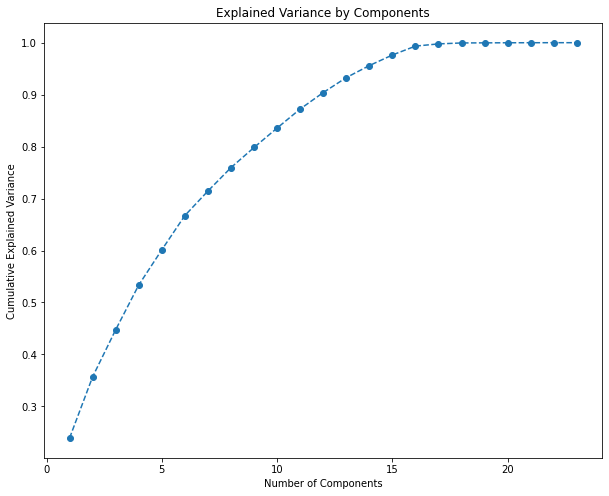

In [80]:
plt.figure(figsize = (10,8))
plt.plot(range(1,24), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

As we want to keep the majority of variance explained by the components we settle for 6 out of the 10 components which roughly preserve 80% of the variance.

In [81]:
pca = PCA(n_components = 9)

In [82]:
pca.fit(taxi_df_customer_types_cluster_selection1_scaled_sample)

PCA(n_components=9)

In [83]:
pca.transform(taxi_df_customer_types_cluster_selection1_scaled_sample)

array([[ 0.99044091,  0.35851983, -0.83283865, ..., -1.02974672,
        -0.12251948,  1.26920326],
       [ 1.18774758,  1.26689461,  2.31512592, ..., -0.17786172,
         2.23029821,  0.17134622],
       [ 0.47756709,  0.09445187,  0.40265242, ..., -0.75334358,
         0.61876472, -0.43701907],
       ...,
       [ 0.79405736,  0.22569479, -0.94868584, ..., -0.20949963,
        -0.56399725,  0.07010755],
       [ 0.02407875, -3.59079971, -0.24892342, ...,  0.83863358,
        -0.22338341, -0.39671663],
       [ 0.89096566,  1.76844758, -1.02371768, ..., -1.48511741,
         0.84946177,  0.61577755]])

In [84]:
scores_pca = pca.transform(taxi_df_customer_types_cluster_selection1_scaled_sample)

In [85]:
taxi_df_customer_types_cluster_selection1_scaled_sample = pd.DataFrame(scores_pca, columns=['Component 1','Component 2','Component 3','Component 4','Component 5','Component 6','Component 7','Component 8','Component 9'])

In [86]:
taxi_df_customer_types_cluster_selection1_scaled_sample

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9
0,0.990441,0.358520,-0.832839,0.828298,1.355972,2.226854,-1.029747,-0.122519,1.269203
1,1.187748,1.266895,2.315126,0.726670,-1.351983,-0.867728,-0.177862,2.230298,0.171346
2,0.477567,0.094452,0.402652,-1.470090,0.386996,3.027865,-0.753344,0.618765,-0.437019
3,0.853624,0.560676,-0.322648,0.679691,0.999098,-0.457419,0.548705,-0.664000,-0.068801
4,1.037872,1.760975,-0.736793,1.284616,0.462171,-0.526978,0.304341,-0.616089,0.100122
...,...,...,...,...,...,...,...,...,...
199995,-4.479981,1.508921,0.414672,1.749966,0.483069,1.233835,-0.352673,1.528082,-0.340621
199996,2.639496,0.161827,-0.980575,-0.208171,1.744501,1.199284,0.110313,-0.301288,-0.341756
199997,0.794057,0.225695,-0.948686,0.224040,1.383704,2.348672,-0.209500,-0.563997,0.070108
199998,0.024079,-3.590800,-0.248923,-0.710168,-0.185892,0.483092,0.838634,-0.223383,-0.396717


### Hard Clustering with KMeans (Sample)

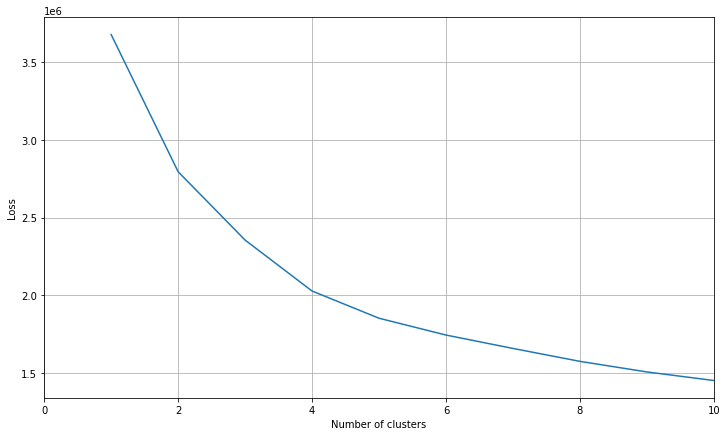

In [87]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLossKM(10, taxi_df_customer_types_cluster_selection1_scaled_sample)

In [88]:
# Calculating KMeans
calcKMeans(4, taxi_df_customer_types_cluster_selection1_scaled_sample)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_selection1_sample.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_selection1_scaled_sample['ClusterKM']
taxi_df_customer_types_cluster_selection1_sample

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM
0,534,3.30,17031841900,17031837000,11.50,6394,3427,391,46,138,...,22,12,357,-2.1,85,-6.8,0.0,29,13.3,2
1,2160,17.80,17031081500,17031980000,56.70,6394,3427,391,46,138,...,12,6,155,20.1,68,23.1,0.0,24,3.7,2
2,662,3.07,17031320100,17031838200,13.75,6394,3427,391,46,138,...,10,12,364,-0.1,72,-6.4,0.0,13,24.7,2
3,1320,4.10,17031839100,17031070500,18.80,6394,3427,391,46,138,...,18,7,197,19.5,78,19.0,0.0,100,16.0,2
4,971,6.60,17031839100,17031062800,19.25,6394,3427,391,46,138,...,21,8,231,24.0,88,26.6,0.0,31,15.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,985,3.78,17031071400,17031833100,16.20,15180,11682,1188,66,396,...,18,10,281,15.7,61,13.1,0.0,73,14.2,3
199996,900,0.10,17031841000,17031320100,13.75,3024,1728,144,0,96,...,18,10,294,12.1,78,8.1,0.0,100,24.6,2
199997,720,0.90,17031839100,17031320100,12.75,6394,3427,391,46,138,...,18,12,336,4.7,67,-0.6,0.0,81,20.5,2
199998,240,1.30,17031320100,17031081402,8.50,6394,3427,391,46,138,...,11,2,43,-6.9,58,-13.6,0.0,92,21.6,1


In [89]:
describeData(taxi_df_customer_types_cluster_selection1_sample, taxi_df_customer_types_cluster_selection1_sample, 4, 'KMeans')

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM
count,16287.000000,16287.000000,1.628700e+04,1.628700e+04,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,...,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.0
mean,2101.461964,12.421736,1.703196e+10,1.703142e+10,48.179960,330.317492,167.686376,19.208510,29.245595,9.066065,...,15.331798,6.711610,189.352183,13.197931,72.607478,11.582440,0.132019,48.123657,14.171358,0.0
std,2450.058321,7.938470,1.081332e+05,3.685975e+05,103.157432,1185.077005,663.218222,73.122347,40.269593,35.874598,...,5.334408,3.221608,98.471096,10.281287,12.660827,13.164164,0.580787,36.640551,7.040746,0.0
min,0.000000,0.000000,1.703102e+10,1.703101e+10,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,-19.700000,32.000000,-25.600000,0.000000,0.000000,0.000000,0.0
25%,1380.000000,3.400000,1.703198e+10,1.703108e+10,41.400000,36.000000,16.000000,0.000000,8.000000,2.000000,...,12.000000,4.000000,109.000000,5.500000,64.000000,1.600000,0.000000,14.000000,8.700000,0.0
50%,1920.000000,15.900000,1.703198e+10,1.703132e+10,50.400000,36.000000,16.000000,0.000000,8.000000,2.000000,...,16.000000,7.000000,191.000000,14.400000,73.000000,12.200000,0.000000,41.000000,13.300000,0.0
75%,2640.000000,17.700000,1.703198e+10,1.703184e+10,57.600000,252.000000,96.000000,6.000000,8.000000,2.000000,...,20.000000,10.000000,277.000000,22.150000,82.000000,22.900000,0.000000,87.000000,18.700000,0.0
max,86393.000000,58.400000,1.703198e+10,1.703198e+10,7141.080000,15180.000000,11682.000000,1188.000000,192.000000,720.000000,...,23.000000,12.000000,366.000000,31.700000,100.000000,37.500000,11.000000,100.000000,49.200000,0.0


,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM
count,53050.000000,53050.000000,5.305000e+04,5.305000e+04,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,...,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.000000,53050.0
mean,568.478662,1.807328,1.703133e+10,1.703137e+10,10.841743,6350.254779,3406.663091,387.418624,46.054364,138.392026,...,14.225957,2.770707,68.608030,2.947791,72.536814,-1.484368,0.144665,59.463977,16.116428,1.0
std,461.336039,3.150043,3.030460e+05,3.325011e+05,9.160908,458.065067,254.894859,31.518171,9.554416,19.105188,...,5.693058,1.268739,37.986274,6.305562,14.356630,7.249612,0.523099,37.298494,7.830367,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,36.000000,14.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,-17.900000,32.000000,-24.600000,0.000000,0.000000,0.500000,1.0
25%,300.000000,0.500000,1.703108e+10,1.703108e+10,6.500000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,10.000000,2.000000,37.000000,-0.700000,63.000000,-6.000000,0.000000,24.000000,10.200000,1.0
50%,478.000000,1.000000,1.703128e+10,1.703128e+10,8.250000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,15.000000,3.000000,69.000000,3.200000,73.000000,-1.100000,0.000000,69.000000,15.100000,1.0
75%,665.000000,1.700000,1.703133e+10,1.703184e+10,11.000000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,19.000000,4.000000,99.000000,7.600000,84.000000,3.700000,0.000000,100.000000,21.100000,1.0
max,13440.000000,50.000000,1.703198e+10,1.703198e+10,118.250000,7744.000000,4992.000000,391.000000,192.000000,448.000000,...,23.000000,5.000000,142.000000,17.200000,100.000000,15.700000,7.100000,100.000000,49.200000,1.0


,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM
count,98756.000000,98756.000000,9.875600e+04,9.875600e+04,98756.000000,98756.000000,98756.000000,98756.00000,98756.000000,98756.000000,...,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.0
mean,644.280327,2.223024,1.703132e+10,1.703137e+10,11.599571,6336.954302,3397.633096,386.87297,45.371734,137.373122,...,14.124084,8.578132,246.587357,16.709398,73.189852,16.157489,0.124227,44.522611,13.563759,2.0
std,547.548713,3.910636,2.945701e+05,3.329841e+05,10.103002,460.689420,239.539066,33.06823,5.847035,7.695276,...,5.560198,2.237139,67.974970,9.600707,11.865255,12.487780,0.580142,35.639544,6.781625,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,54.000000,30.000000,0.00000,0.000000,0.000000,...,0.000000,4.000000,106.000000,-19.700000,40.000000,-25.700000,0.000000,0.000000,0.000000,2.0
25%,337.000000,0.600000,1.703108e+10,1.703108e+10,6.750000,6394.000000,3427.000000,391.00000,46.000000,138.000000,...,11.000000,7.000000,189.000000,11.800000,65.000000,9.400000,0.000000,12.000000,8.300000,2.0
50%,499.000000,1.100000,1.703128e+10,1.703128e+10,8.750000,6394.000000,3427.000000,391.00000,46.000000,138.000000,...,15.000000,9.000000,248.000000,19.300000,73.000000,19.200000,0.000000,35.000000,12.700000,2.0
75%,780.000000,1.900000,1.703132e+10,1.703184e+10,11.750000,6394.000000,3427.000000,391.00000,46.000000,138.000000,...,18.000000,10.000000,305.000000,23.700000,82.000000,25.600000,0.000000,81.000000,17.800000,2.0
max,10500.000000,41.800000,1.703198e+10,1.703198e+10,278.000000,6394.000000,3427.000000,391.00000,108.000000,282.000000,...,23.000000,12.000000,366.000000,31.700000,100.000000,37.500000,11.000000,100.000000,41.000000,2.0


,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,end_hour,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM
count,31907.000000,31907.000000,3.190700e+04,3.190700e+04,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,...,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.000000,31907.0
mean,664.310371,2.457219,1.703132e+10,1.703130e+10,12.123619,13753.450967,10283.217538,1081.619268,92.316357,489.392359,...,12.617795,6.201210,173.862601,11.431448,74.927571,9.466446,0.118936,45.753910,14.154794,3.0
std,544.411640,3.668909,3.453556e+05,3.240006e+05,8.132352,2164.431181,2085.822417,194.191461,40.023801,144.436275,...,7.833998,3.312333,101.137168,10.418142,12.788566,13.358779,0.516328,36.403033,7.035406,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,7744.000000,4992.000000,320.000000,66.000000,396.000000,...,0.000000,1.000000,1.000000,-19.700000,32.000000,-25.600000,0.000000,0.000000,0.000000,3.0
25%,360.000000,0.600000,1.703107e+10,1.703107e+10,7.500000,11232.000000,7704.000000,936.000000,66.000000,396.000000,...,5.000000,3.000000,87.000000,2.700000,66.000000,-1.700000,0.000000,12.000000,8.900000,3.0
50%,564.000000,1.600000,1.703108e+10,1.703108e+10,10.250000,15180.000000,11682.000000,1188.000000,66.000000,396.000000,...,14.000000,6.000000,169.000000,11.600000,76.000000,8.600000,0.000000,36.000000,13.100000,3.0
75%,840.000000,2.900000,1.703183e+10,1.703133e+10,14.000000,15180.000000,11682.000000,1188.000000,144.000000,720.000000,...,20.000000,9.000000,260.000000,20.900000,85.000000,21.400000,0.000000,85.000000,18.400000,3.0
max,22860.000000,56.700000,1.703184e+10,1.703198e+10,135.860000,15180.000000,11682.000000,1188.000000,192.000000,720.000000,...,23.000000,12.000000,366.000000,31.700000,100.000000,37.500000,11.000000,100.000000,48.900000,3.0


Cluster Descriptions

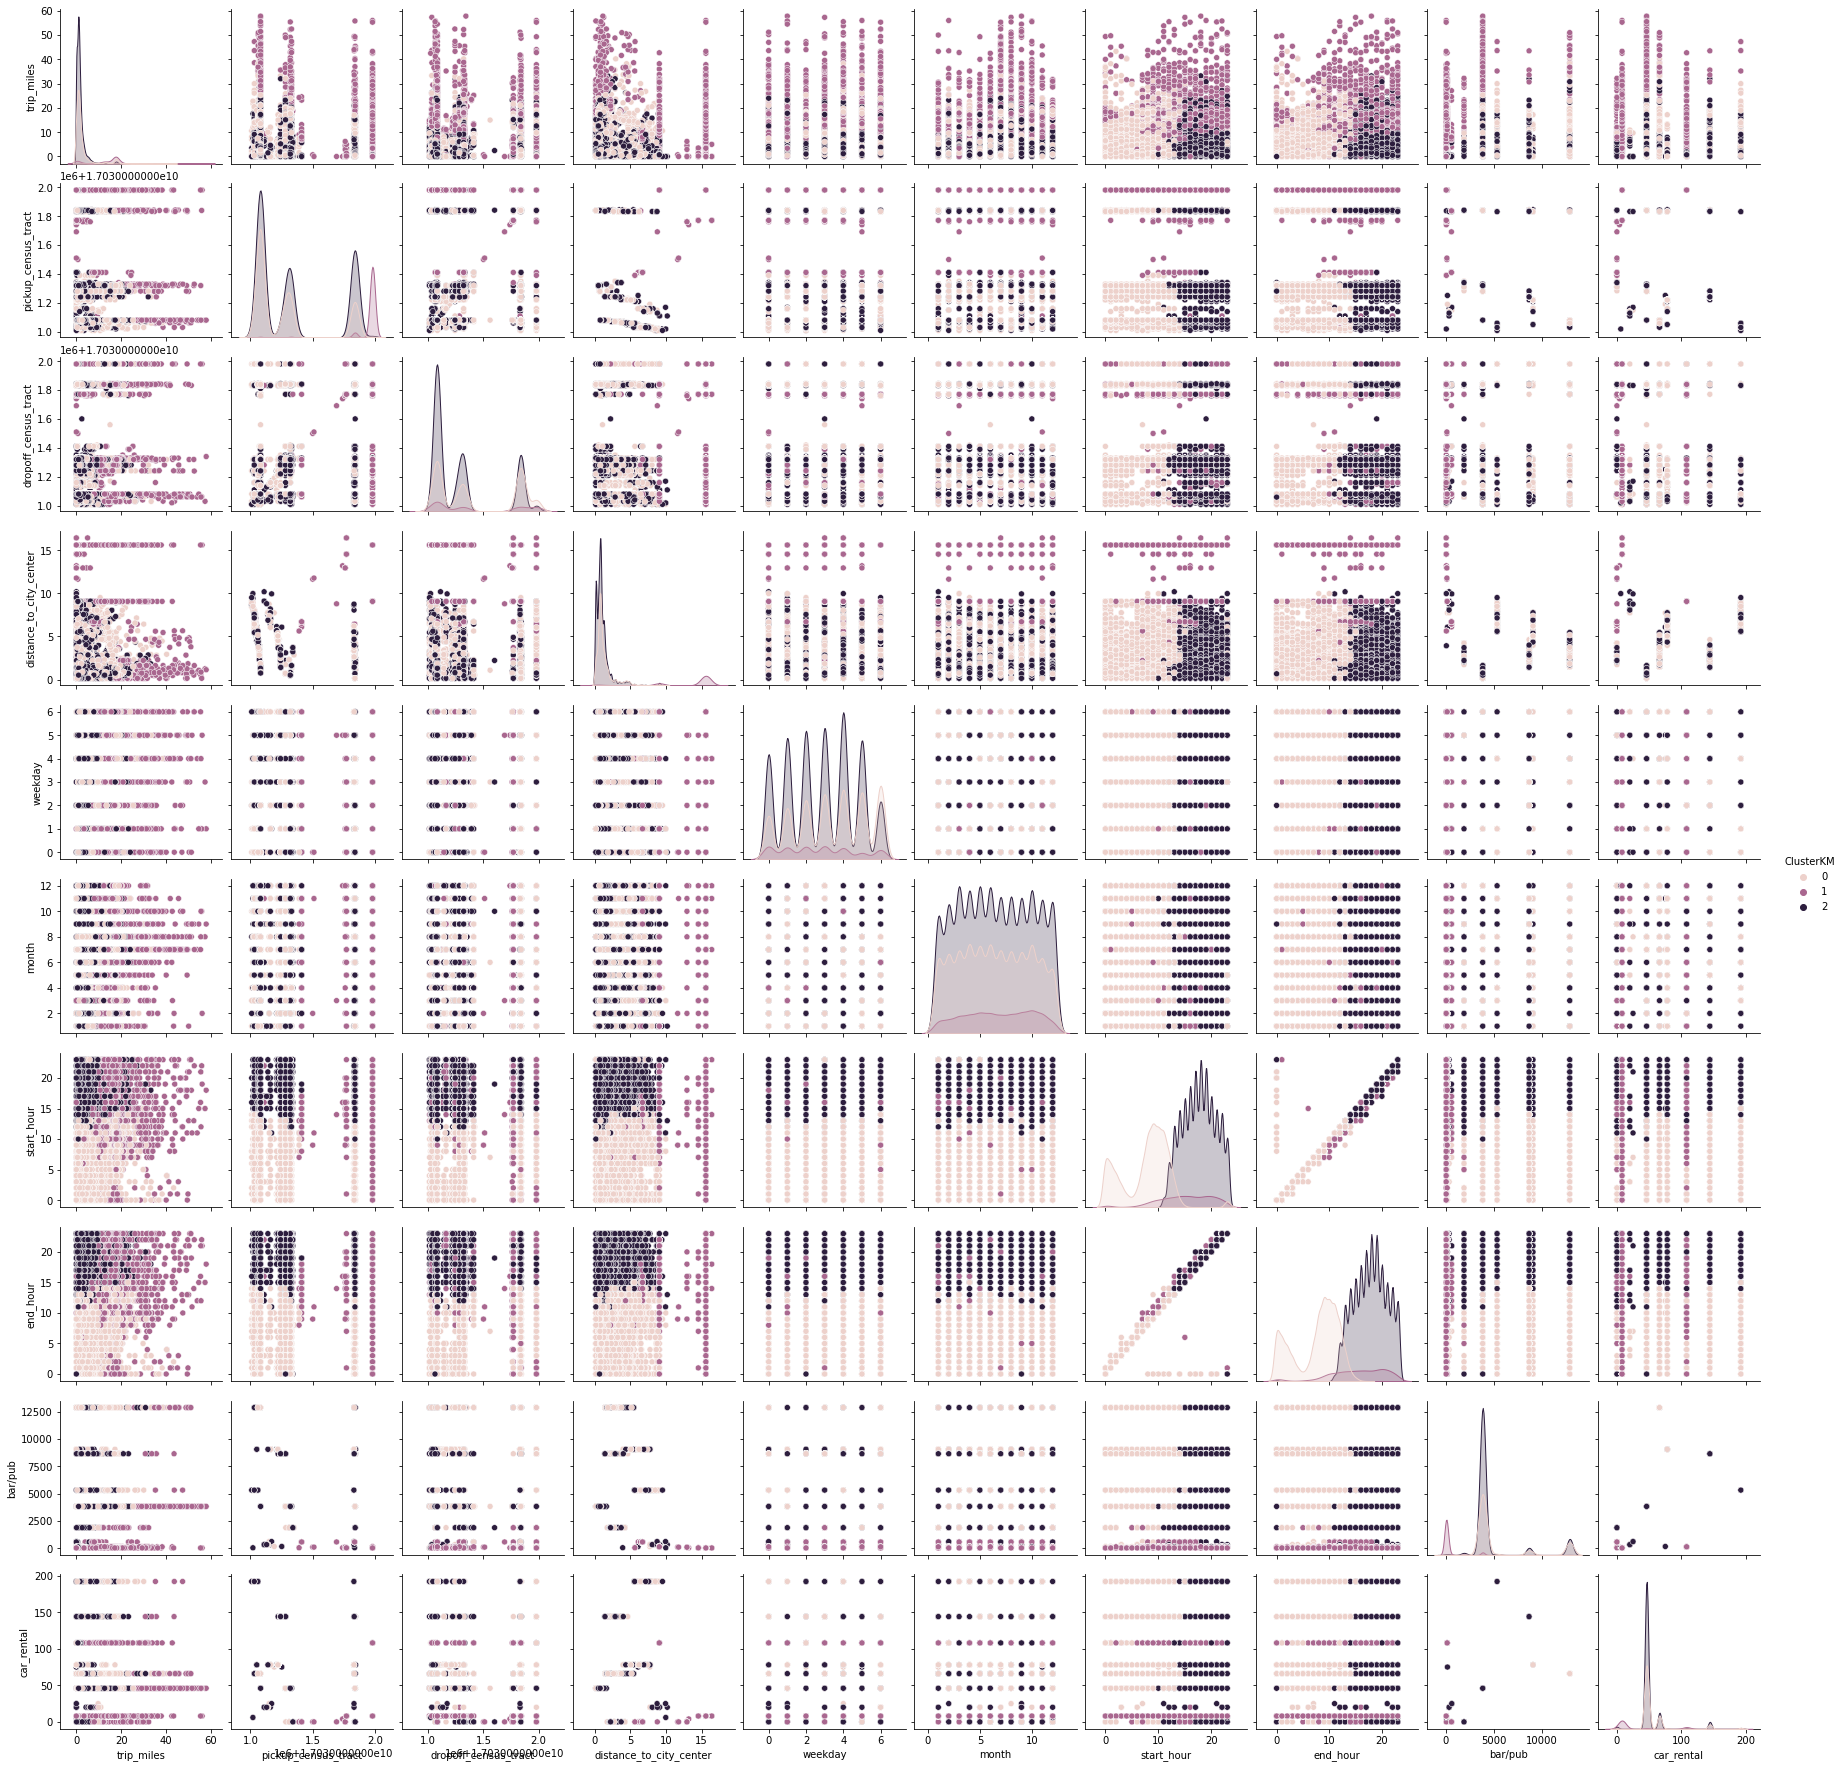

In [46]:
#Plot Clustering Results
sns.pairplot(taxi_df_customer_types_cluster_selection1_sample, hue="ClusterKM")

In [ ]:
#Plot Clustering Results
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

fig = plt.scatter (x=taxi_df_customer_types_cluster_selection1_sample['weekday'], y=taxi_df_customer_types_cluster_selection1_sample['hour'],c=taxi_df_customer_types_cluster_selection1_sample['ClusterKM'].map(colors))
fig

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1_sample['hour'], ys=taxi_df_customer_types_cluster_selection1_sample['weekday'], zs=taxi_df_customer_types_cluster_selection1_sample['bar/pub'], c=taxi_df_customer_types_cluster_selection1_sample['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering Results KMeans')
plt.xlabel('distance_to_city_center')
plt.ylabel('weekday')
ax.set_zlabel('n_poi')
ax.zaxis.labelpad = 0
plt.show()

### Soft Clustering with Gaussian Mixture Model (Sample)

In [90]:
taxi_df_customer_types_cluster_selection1_scaled_sample.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_selection1_scaled_sample

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9
0,0.990441,0.358520,-0.832839,0.828298,1.355972,2.226854,-1.029747,-0.122519,1.269203
1,1.187748,1.266895,2.315126,0.726670,-1.351983,-0.867728,-0.177862,2.230298,0.171346
2,0.477567,0.094452,0.402652,-1.470090,0.386996,3.027865,-0.753344,0.618765,-0.437019
3,0.853624,0.560676,-0.322648,0.679691,0.999098,-0.457419,0.548705,-0.664000,-0.068801
4,1.037872,1.760975,-0.736793,1.284616,0.462171,-0.526978,0.304341,-0.616089,0.100122
...,...,...,...,...,...,...,...,...,...
199995,-4.479981,1.508921,0.414672,1.749966,0.483069,1.233835,-0.352673,1.528082,-0.340621
199996,2.639496,0.161827,-0.980575,-0.208171,1.744501,1.199284,0.110313,-0.301288,-0.341756
199997,0.794057,0.225695,-0.948686,0.224040,1.383704,2.348672,-0.209500,-0.563997,0.070108
199998,0.024079,-3.590800,-0.248923,-0.710168,-0.185892,0.483092,0.838634,-0.223383,-0.396717


In [91]:
# GMM
calcGMM(3, taxi_df_customer_types_cluster_selection1_scaled_sample)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_selection1_sample.loc[:, 'ClusterGMM'] = taxi_df_customer_types_cluster_selection1_scaled_sample['ClusterGMM']
taxi_df_customer_types_cluster_selection1_sample

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM,ClusterGMM
0,534,3.30,17031841900,17031837000,11.50,6394,3427,391,46,138,...,12,357,-2.1,85,-6.8,0.0,29,13.3,2,0
1,2160,17.80,17031081500,17031980000,56.70,6394,3427,391,46,138,...,6,155,20.1,68,23.1,0.0,24,3.7,2,2
2,662,3.07,17031320100,17031838200,13.75,6394,3427,391,46,138,...,12,364,-0.1,72,-6.4,0.0,13,24.7,2,0
3,1320,4.10,17031839100,17031070500,18.80,6394,3427,391,46,138,...,7,197,19.5,78,19.0,0.0,100,16.0,2,2
4,971,6.60,17031839100,17031062800,19.25,6394,3427,391,46,138,...,8,231,24.0,88,26.6,0.0,31,15.5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,985,3.78,17031071400,17031833100,16.20,15180,11682,1188,66,396,...,10,281,15.7,61,13.1,0.0,73,14.2,3,1
199996,900,0.10,17031841000,17031320100,13.75,3024,1728,144,0,96,...,10,294,12.1,78,8.1,0.0,100,24.6,2,0
199997,720,0.90,17031839100,17031320100,12.75,6394,3427,391,46,138,...,12,336,4.7,67,-0.6,0.0,81,20.5,2,0
199998,240,1.30,17031320100,17031081402,8.50,6394,3427,391,46,138,...,2,43,-6.9,58,-13.6,0.0,92,21.6,1,2


In [92]:
describeData(taxi_df_customer_types_cluster_selection1_sample, taxi_df_customer_types_cluster_selection1_sample, 3, 'GMM')

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM,ClusterGMM
count,63126.000000,63126.000000,6.312600e+04,6.312600e+04,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,...,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.000000,63126.0
mean,883.618145,3.926003,1.703141e+10,1.703139e+10,17.371229,5538.872794,2968.938551,337.884659,43.074454,120.454852,...,10.117590,293.707363,12.736163,74.270649,10.809468,0.181999,49.707125,15.392662,1.735434,0.0
std,1388.295969,6.243460,3.527973e+05,3.451086e+05,54.590562,2121.382976,1141.597151,131.137635,16.642808,45.814892,...,1.433982,42.976005,10.194271,11.458749,12.971295,0.762733,37.766618,7.159799,0.676888,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,36.000000,16.000000,0.000000,0.000000,0.000000,...,1.000000,20.000000,-19.700000,40.000000,-25.700000,0.000000,0.000000,0.000000,0.000000,0.0
25%,360.000000,0.600000,1.703108e+10,1.703108e+10,7.000000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,9.000000,264.000000,6.300000,66.000000,1.600000,0.000000,12.000000,9.900000,2.000000,0.0
50%,540.000000,1.200000,1.703132e+10,1.703128e+10,9.500000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,10.000000,296.000000,14.600000,74.000000,12.300000,0.000000,46.000000,14.800000,2.000000,0.0
75%,1008.000000,2.900000,1.703184e+10,1.703184e+10,15.000000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,11.000000,328.000000,21.000000,83.000000,21.400000,0.000000,89.000000,20.200000,2.000000,0.0
max,86393.000000,58.400000,1.703198e+10,1.703198e+10,7141.080000,15180.000000,11682.000000,1188.000000,192.000000,448.000000,...,12.000000,366.000000,31.700000,100.000000,37.500000,11.000000,100.000000,41.000000,2.000000,0.0


,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM,ClusterGMM
count,32071.000000,32071.000000,3.207100e+04,3.207100e+04,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,...,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.000000,32071.0
mean,667.416077,2.461551,1.703131e+10,1.703130e+10,12.138803,13723.061333,10256.453244,1077.770883,92.820679,489.187553,...,6.177918,173.145209,11.351174,74.889838,9.367410,0.118749,45.833214,14.172608,2.989648,1.0
std,629.527629,3.680203,3.452746e+05,3.241381e+05,8.157452,2200.583791,2114.091807,201.081693,40.543295,144.103078,...,3.320575,101.397423,10.461019,12.799071,13.404991,0.515976,36.409509,7.043500,0.144816,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,7744.000000,4992.000000,320.000000,66.000000,396.000000,...,1.000000,1.000000,-19.700000,32.000000,-25.600000,0.000000,0.000000,0.000000,0.000000,1.0
25%,360.000000,0.600000,1.703107e+10,1.703107e+10,7.500000,11232.000000,7704.000000,936.000000,66.000000,396.000000,...,3.000000,86.000000,2.500000,66.000000,-1.800000,0.000000,12.000000,8.900000,3.000000,1.0
50%,565.000000,1.600000,1.703108e+10,1.703108e+10,10.250000,15180.000000,11682.000000,1188.000000,66.000000,396.000000,...,6.000000,168.000000,11.400000,76.000000,8.500000,0.000000,36.000000,13.100000,3.000000,1.0
75%,840.000000,2.900000,1.703183e+10,1.703133e+10,14.000000,15180.000000,11682.000000,1188.000000,144.000000,720.000000,...,9.000000,260.000000,20.800000,85.000000,21.400000,0.000000,85.000000,18.400000,3.000000,1.0
max,42840.000000,56.700000,1.703184e+10,1.703198e+10,135.860000,15180.000000,11682.000000,1188.000000,192.000000,720.000000,...,12.000000,366.000000,31.700000,100.000000,37.500000,11.000000,100.000000,48.900000,3.000000,1.0


,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,n_poi,bar,pub,car_rental,clinic,...,month,day_of_year,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%),windspeed_10m (km/h),ClusterKM,ClusterGMM
count,104803.000000,104803.000000,1.048030e+05,1.048030e+05,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,...,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.000000,104803.0
mean,687.222913,2.570096,1.703137e+10,1.703137e+10,13.418864,5888.622768,3155.882313,359.609582,44.367108,127.651413,...,4.432001,119.553248,11.623761,72.126619,9.778458,0.101051,49.496388,13.842334,1.343960,2.0
std,653.931726,4.481606,3.334038e+05,3.313461e+05,13.488736,1682.932769,904.303981,103.965543,12.911982,36.266731,...,2.196272,66.892819,11.066628,13.451608,14.173113,0.393736,36.364900,7.234901,0.614505,0.0
min,0.000000,0.000000,1.703101e+10,1.703101e+10,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,-17.900000,32.000000,-24.600000,0.000000,0.000000,0.500000,0.000000,2.0
25%,312.000000,0.500000,1.703108e+10,1.703108e+10,6.750000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,3.000000,63.000000,2.600000,63.000000,-2.000000,0.000000,17.000000,8.400000,1.000000,2.0
50%,480.000000,1.100000,1.703128e+10,1.703128e+10,8.750000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,4.000000,119.000000,10.600000,73.000000,7.500000,0.000000,42.000000,12.600000,1.000000,2.0
75%,780.000000,2.000000,1.703184e+10,1.703183e+10,12.250000,6394.000000,3427.000000,391.000000,46.000000,138.000000,...,6.000000,173.000000,22.100000,82.000000,23.000000,0.000000,89.000000,18.200000,2.000000,2.0
max,25800.000000,50.000000,1.703198e+10,1.703198e+10,550.000000,6394.000000,3427.000000,391.000000,108.000000,282.000000,...,9.000000,267.000000,31.700000,100.000000,37.500000,6.600000,100.000000,49.200000,2.000000,2.0


In [ ]:
taxi_df_customer_types_cluster_selection1_sample.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_selection1_sample

In [ ]:
#Plot Clustering Results
sns.pairplot(taxi_df_customer_types_cluster_selection1_sample, hue="ClusterGMM")

In [ ]:
#Plot Clustering Results
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

fig = plt.scatter (x=taxi_df_customer_types_cluster_selection1_sample['hour'], y=taxi_df_customer_types_cluster_selection1_sample['trip_seconds'],c=taxi_df_customer_types_cluster_sample['ClusterGMM'].map(colors))
fig


In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1_sample['hour'], ys=taxi_df_customer_types_cluster_selection1_sample['trip_seconds'], zs=taxi_df_customer_types_cluster_selection1_sample['distance_to_city_center'], c=taxi_df_customer_types_cluster_selection1_sample['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KMeans Clustering of Customer Types')
plt.xlabel('hour')
plt.ylabel('trip seconds')
ax.set_zlabel('distance to city center')
ax.zaxis.labelpad = 0
plt.show()